# Adaptive Decision Trees

Using iris dataset from scikit-learn.

In [139]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

from sklearn import datasets

## Load + Explore Data

In [31]:
data = datasets.load_iris()
X, Y = data.data, data.target
print(data.feature_names)
print(data.target_names)
print(len(X))

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
150


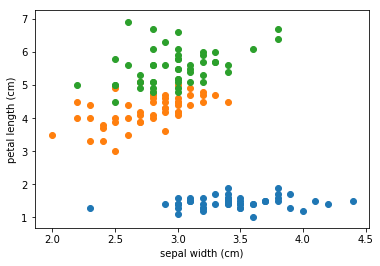

In [46]:
feat1, feat2 = (1, 2) # edit this
plt.scatter(X[Y == 0][:, feat1], X[Y == 0][:, feat2], label=data.target_names[0])
plt.scatter(X[Y == 1][:, feat1], X[Y == 1][:, feat2], label=data.target_names[1])
plt.scatter(X[Y == 2][:, feat1], X[Y == 2][:, feat2], label=data.target_names[2])
plt.xlabel(data.feature_names[feat1])
plt.ylabel(data.feature_names[feat2])
plt.show()

In [550]:
# pick 2 dimensions for easy viz
X2d = X[:, [1, 2]]
# blot out all but 50 labels
Ysmall = Y.copy()
mask = np.random.choice(np.arange(Y.size), size=150-50, replace=False)
Ysmall[mask] = -1

## Implement k-D Tree

Can just use sp.spatial.KDTree once understand.

This is not optimized, purpose is visualization.

In [551]:
np.random.shuffle(list(zip(X, Y)))

In [602]:
# Node of K-D Tree, corresponds to a specialist.
class TreeNode:
    
    def __init__(self, bounds):
        self.bounds = bounds
        self.left = self.right = None
        self.split_point = self.split_dim = None
    
    def split(self, x, d):
        self.split_point = x
        self.split_dim = d
        bounds_left = self.bounds.copy()
        bounds_right = self.bounds.copy()
        bounds_left[d][1] = x
        bounds_right[d][0] = x
        self.left = TreeNode(bounds_left)
        self.right = TreeNode(bounds_right)

    # propagate bias from children
    def prop_bias(self):
        if self.split_point is None:
            return
        pass
        
class KDTree:
    
    def __init__(self, X, Y):
        both = list(zip(X, Y))
        np.random.shuffle(both)
        self.X, self.Y = zip(*both)
        self.X, self.Y = np.array(self.X), np.array(self.Y)
        self.root = TreeNode(np.array([[self.X[:, d].min(), self.X[:, d].max()]
                                   for d in range(X.shape[1])]))
        for i in range(self.X.shape[0]):
            self.insert(self.X[i])
    
    def insert(self, x):
        d = 0
        node = self.root
        while node.split_point:
            side = 'left' if x[d] < node.split_point else 'right'
            node = getattr(node, side)
            d = (d + 1) % x.size
        node.split(x[d], d)
    
    # get sequence of specialists converging to {x}
    def get_seq(self, x):
        seq = []
        d = 0
        node = self.root
        while node.split_point:
            seq.append(node.bounds)
            node = node.left if x[d] < node.split_point else node.right
            d = (d + 1) % x.size
        return seq
    
    ## VISUALIZATION METHODS
    # visualize dataset
    def viz_data(self):
        for y in [-1, 0, 1, 2]:
            plt.scatter(self.X[self.Y == y][:, 0], self.X[self.Y == y][:, 1],
                        label=(list(data.target_names)+['removed label'])[y])
        plt.title('Iris Plants Dataset')
        plt.xlabel(data.feature_names[0])
        plt.ylabel(data.feature_names[1])
        plt.legend(loc='best')
    
    # visualize entire decision tree
    def viz_tree(self, depth=np.inf):
        # recursively DFS through tree adding dividers to visualization
        dim = self.X.shape[1]
        assert dim == 2
        vlines, hlines = [], []
        def recurse(node, d, rec_depth=0):
            if rec_depth > depth:
                return
            if node is None:
                return
            [plt.vlines, plt.hlines][d]([node.split_point], *node.bounds[1-d])
            # make new specialist contexts for recursion
            d = (d + 1) % dim
            recurse(node.left, d, rec_depth+1)
            recurse(node.right, d, rec_depth+1)
        recurse(self.root, 0)
    
    # visualize the sequence of specialists induced by decision tree for a single point
    def viz_point(self, x, ax):
        ax.scatter([x[0]], [x[1]], color='black', s=300, marker='x')
        dim = x.size
        assert dim == 2
        d = 0
        rects = []
        for spec in self.get_seq(x):
            rect = Rectangle(spec[:, 0], spec[0, 1] - spec[0, 0], spec[1, 1] - spec[1, 0])
            rects.append(rect)
            d = (d + 1) % dim
        pc = PatchCollection(rects, facecolor='none', alpha=1, edgecolor='black')
        ax.add_collection(pc)

## Visualize k-D Trees

In [623]:
tree = KDTree(X2d, Ysmall)

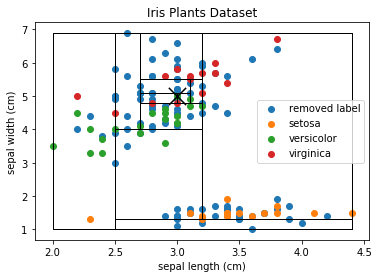

In [624]:
# visualize sequence of specialists for a single point
# dimensions will appear to not alternate when the same coordinate position is selected twice.
fig, ax = plt.subplots()
tree.viz_data()
tree.viz_point(np.array([3, 5]), ax)
plt.show()

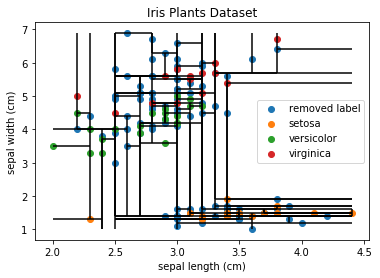

In [571]:
# visualize full tree
fig, ax = plt.subplots()
tree.viz_data()
tree.viz_tree()
plt.show()

In [ ]:
# tree = sp.spatial.KDTree(X2d)

## Active Learning Procedure

In [444]:
N = 20
trees = [KDTree(X2d, Y) for _ in range(N)] # initialize N trees